### Taxi Data for 2015



In [ ]:
import pandas as pd
from datetime import time
from sklearn.impute import KNNImputer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ace_tools_open as tools
import os




* try merging it with another year
* merge the csv number code with the actual csv
https://www.reddit.com/r/dataisbeautiful/comments/d9mirb/oc_how_uber_took_over_new_york_city/#lightbox

In [ ]:
df_2015_01 = pd.read_csv('yellow_tripdata_2015-01.csv')
df_2015_02 = pd.read_csv('yellow_tripdata_2015-02.csv')
df_2015_03 = pd.read_csv('yellow_tripdata_2015-03.csv')
df_2015_04 = pd.read_csv('yellow_tripdata_2015-04.csv')
df_2015_05 = pd.read_csv('yellow_tripdata_2015-05.csv')
df_2015_06 = pd.read_csv('yellow_tripdata_2015-06.csv')
df_2015_07 = pd.read_csv('yellow_tripdata_2015-07.csv')
df_2015_08 = pd.read_csv('yellow_tripdata_2015-08.csv')
df_2015_09 = pd.read_csv('yellow_tripdata_2015-09.csv')
df_2015_10 = pd.read_csv('yellow_tripdata_2015-10.csv')
df_2015_11 = pd.read_csv('yellow_tripdata_2015-11.csv')
df_2015_12 = pd.read_csv('yellow_tripdata_2015-12.csv')

In [ ]:
dfs = [df_2015_01, df_2015_02, df_2015_03, df_2015_04, df_2015_05, df_2015_06,
       df_2015_07, df_2015_08, df_2015_09, df_2015_10, df_2015_11, df_2015_12]

combined_data = pd.concat(dfs, ignore_index=True)
print(combined_data.head())

   Unnamed: 0  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0           0         1  2015-01-01 00:11:33   2015-01-01 00:16:48   
1           1         1  2015-01-01 00:18:24   2015-01-01 00:24:20   
2           2         1  2015-01-01 00:26:19   2015-01-01 00:41:06   
3           3         1  2015-01-01 00:45:26   2015-01-01 00:53:20   
4           4         1  2015-01-01 00:59:21   2015-01-01 01:05:24   

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                1            1.0           1                  N   
1                1            0.9           1                  N   
2                1            3.5           1                  N   
3                1            2.1           1                  N   
4                1            1.0           1                  N   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0            41           166             1          5.7    0.5      0.5   
1           166   

In [ ]:
def preprocess_data(df):
    columns_to_keep = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count",
                       "trip_distance", "fare_amount", "total_amount", "PULocationID",
                       "DOLocationID"]

    df = df[columns_to_keep].copy()

    df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
    df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

    df = df[(df["fare_amount"] > 0) & (df["trip_distance"] > 0)]

    df["trip_duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60

    df = df[(df["trip_duration"] > 1) & (df["trip_duration"] < 300)]

    return df

processed_data = preprocess_data(combined_data)

processed_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,PULocationID,DOLocationID,trip_duration
0,2015-01-01 00:11:33,2015-01-01 00:16:48,1,1.0,5.7,8.40,41,166,5.250000
1,2015-01-01 00:18:24,2015-01-01 00:24:20,1,0.9,6.0,7.30,166,238,5.933333
2,2015-01-01 00:26:19,2015-01-01 00:41:06,1,3.5,13.2,17.40,238,162,14.783333
3,2015-01-01 00:45:26,2015-01-01 00:53:20,1,2.1,8.2,11.87,162,263,7.900000
4,2015-01-01 00:59:21,2015-01-01 01:05:24,1,1.0,6.0,7.30,236,141,6.050000


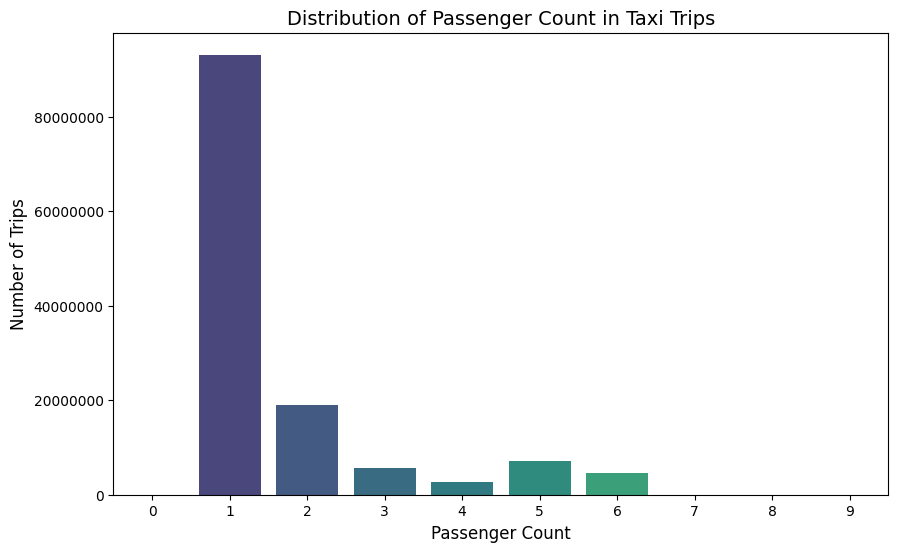

In [ ]:
passenger_counts = processed_data['passenger_count'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=passenger_counts.index, y=passenger_counts.values, palette="viridis")

plt.xlabel("Passenger Count", fontsize=12)
plt.ylabel("Number of Trips", fontsize=12)
plt.title("Distribution of Passenger Count in Taxi Trips", fontsize=14)

plt.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=0)

plt.show()

### Since these zero-passenger trips do not represent valid taxi rides, removing them will
- Improve data quality by ensuring only valid trips are analyzed
- Reduce noise in machine learning models
- Keep the dataset consistent with the real-world taxi business model

In [ ]:
filtered_df = processed_data[processed_data['passenger_count'] != 0]
filtered_df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,PULocationID,DOLocationID,trip_duration
0,2015-01-01 00:11:33,2015-01-01 00:16:48,1,1.0,5.7,8.40,41,166,5.250000
1,2015-01-01 00:18:24,2015-01-01 00:24:20,1,0.9,6.0,7.30,166,238,5.933333
2,2015-01-01 00:26:19,2015-01-01 00:41:06,1,3.5,13.2,17.40,238,162,14.783333
3,2015-01-01 00:45:26,2015-01-01 00:53:20,1,2.1,8.2,11.87,162,263,7.900000
4,2015-01-01 00:59:21,2015-01-01 01:05:24,1,1.0,6.0,7.30,236,141,6.050000


In [ ]:
summary_data = {
    "Column": filtered_df.columns,
    "Data Type": filtered_df.dtypes.values,
    "Missing Values": filtered_df.isnull().sum().values,
    "Unique Values": filtered_df.nunique().values
}

summary_table = pd.DataFrame(summary_data)

numeric_cols = filtered_df.select_dtypes(include=["number"]).columns

summary_table = summary_table.merge(
    pd.DataFrame({
        "Column": numeric_cols,
        "Min": filtered_df[numeric_cols].min().values,
        "Max": filtered_df[numeric_cols].max().values,
        "Mean": filtered_df[numeric_cols].mean().values,
        "Median": filtered_df[numeric_cols].median().values,
        "Standard Deviation": filtered_df[numeric_cols].std().values
    }),
    on="Column",
    how="left"
)

tools.display_dataframe_to_user(name="Dataset Summary", dataframe=summary_table)

Dataset Summary


In [ ]:
filtered_df['pickup_date'] = filtered_df['tpep_pickup_datetime'].dt.date

daily_avg_data = filtered_df.groupby('pickup_date').agg({
    'passenger_count': 'mean',
    'trip_distance': 'mean',
    'fare_amount': 'mean',
    'trip_duration': 'mean',
    'PULocationID': 'nunique',
    'DOLocationID': 'nunique'
}).reset_index()


daily_avg_data.rename(columns={
    'passenger_count': 'avg_passenger_count',
    'trip_distance': 'avg_trip_distance',
    'fare_amount': 'avg_fare_amount',
    'trip_duration': 'avg_trip_duration',
    'PULocationID': 'unique_pickup_locations',
    'DOLocationID': 'unique_dropoff_locations'
}, inplace=True)

daily_avg_data['pickup_date'] = pd.to_datetime(daily_avg_data['pickup_date'])

daily_avg_data["day_of_week"] = daily_avg_data['pickup_date'].dt.day_name()

column_order = ['pickup_date', 'day_of_week', 'avg_passenger_count', 'avg_trip_distance',
                'avg_fare_amount', 'avg_trip_duration', 'unique_pickup_locations', 'unique_dropoff_locations']

daily_avg_data = daily_avg_data[column_order]

tools.display_dataframe_to_user(name="Daily Average Taxi Data", dataframe=daily_avg_data)

C:\Users\Arjun\AppData\Local\Temp\ipykernel_6892\1422847365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['pickup_date'] = filtered_df['tpep_pickup_datetime'].dt.date


Daily Average Taxi Data


In [ ]:
daily_avg_data.to_csv("daily_taxi_data_2015.csv", index=False)

In [ ]:
filtered_df['pickup_month'] = pd.to_datetime(filtered_df['tpep_pickup_datetime']).dt.to_period('M')

monthly_avg_data = filtered_df.groupby('pickup_month').agg({
    'passenger_count': 'mean',
    'trip_distance': 'mean',
    'fare_amount': 'mean',
    'trip_duration': 'mean',
    'PULocationID': 'nunique',
    'DOLocationID': 'nunique'
}).reset_index()

monthly_avg_data.rename(columns={
    'passenger_count': 'avg_passenger_count',
    'trip_distance': 'avg_trip_distance',
    'fare_amount': 'avg_fare_amount',
    'trip_duration': 'avg_trip_duration',
    'PULocationID': 'unique_pickup_locations',
    'DOLocationID': 'unique_dropoff_locations'
}, inplace=True)

monthly_avg_data['pickup_month'] = monthly_avg_data['pickup_month'].astype(str)

tools.display_dataframe_to_user(name="Monthly Average Taxi Data", dataframe=monthly_avg_data)

C:\Users\Arjun\AppData\Local\Temp\ipykernel_6892\842196576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['pickup_month'] = pd.to_datetime(filtered_df['tpep_pickup_datetime']).dt.to_period('M')


Monthly Average Taxi Data


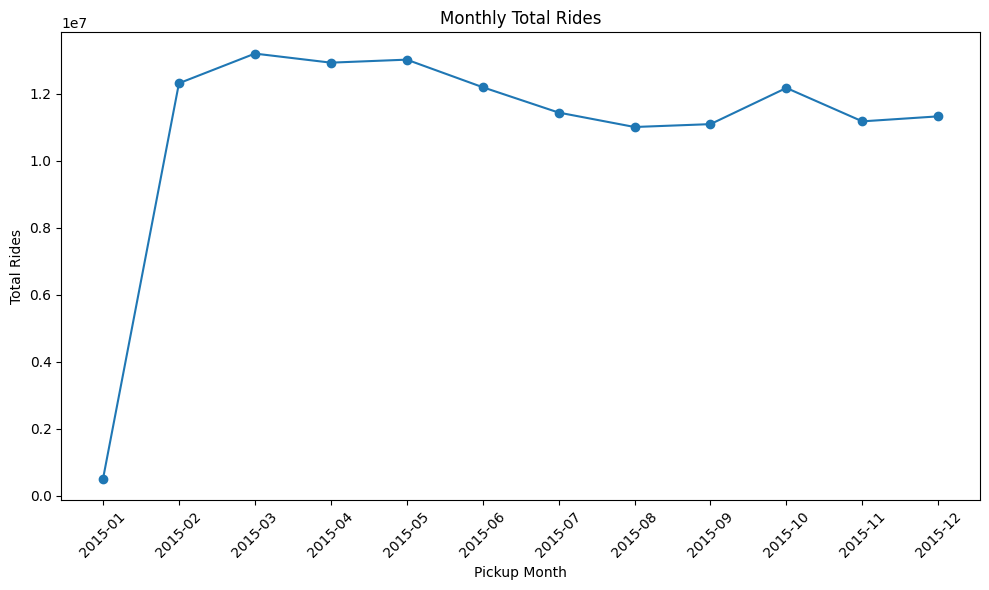

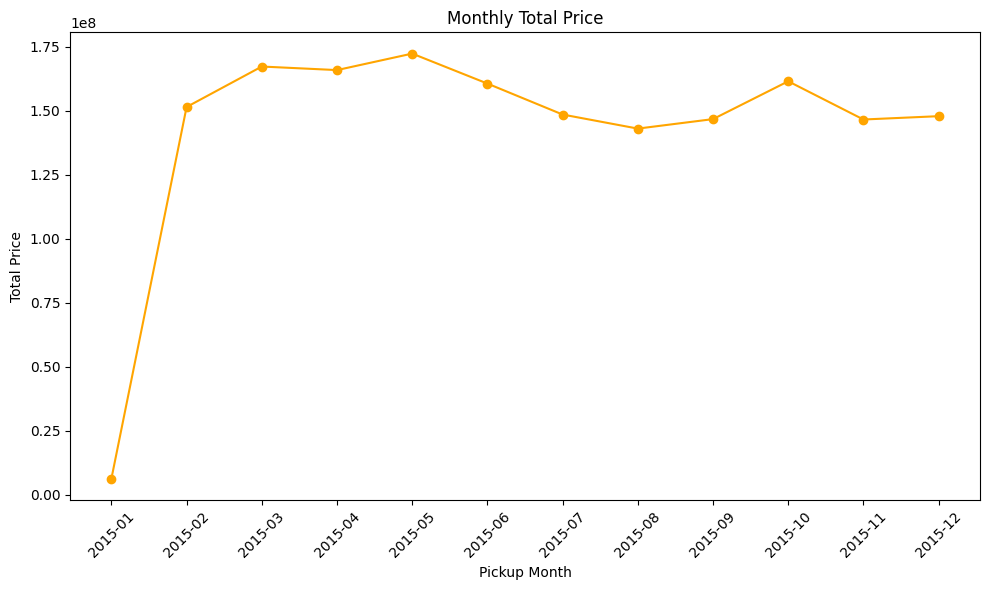

In [ ]:
monthly_rides = filtered_df.groupby('pickup_month').size().reset_index(name='total_rides')

monthly_rides['pickup_month'] = monthly_rides['pickup_month'].astype(str)

plt.figure(figsize=(10, 6))
plt.plot(monthly_rides['pickup_month'], monthly_rides['total_rides'], marker='o')
plt.title("Monthly Total Rides")
plt.xlabel("Pickup Month")
plt.xticks(rotation=45)
plt.ylabel("Total Rides")
plt.tight_layout()
plt.show()

monthly_price = filtered_df.groupby('pickup_month')['fare_amount'].sum().reset_index(name='total_price')

monthly_price['pickup_month'] = monthly_price['pickup_month'].astype(str)

plt.figure(figsize=(10, 6))
plt.plot(monthly_price['pickup_month'], monthly_price['total_price'], marker='o', color='orange')
plt.title("Monthly Total Price")
plt.xlabel("Pickup Month")
plt.xticks(rotation=45)
plt.ylabel("Total Price")
plt.tight_layout()
plt.show()

In [ ]:
taxi_data = pd.read_csv("taxi_zone_lookup.csv")

pickup_df = filtered_df.merge(taxi_data[['LocationID', 'Borough']],
                              left_on="PULocationID", right_on="LocationID",
                              how="left")
pickup_df.rename(columns={"Borough": "Pickup_Borough"}, inplace=True)
pickup_df.drop(columns=["LocationID"], inplace=True)

dropoff_df = filtered_df.merge(taxi_data[['LocationID', 'Borough']],
                               left_on="DOLocationID", right_on="LocationID",
                               how="left")
dropoff_df.rename(columns={"Borough": "Dropoff_Borough"}, inplace=True)
dropoff_df.drop(columns=["LocationID"], inplace=True)

pickup_tallies = pickup_df.groupby(["pickup_date", "Pickup_Borough"]).size().reset_index(name="Count")
pickup_pivot = pickup_tallies.pivot(index="pickup_date", columns="Pickup_Borough", values="Count").fillna(0)
pickup_pivot.columns = [f"{col}_Pickups" for col in pickup_pivot.columns]

dropoff_tallies = dropoff_df.groupby(["pickup_date", "Dropoff_Borough"]).size().reset_index(name="Count")
dropoff_pivot = dropoff_tallies.pivot(index="pickup_date", columns="Dropoff_Borough", values="Count").fillna(0)
dropoff_pivot.columns = [f"{col}_Dropoffs" for col in dropoff_pivot.columns]

final_borough_tallies = pickup_pivot.join(dropoff_pivot, how="outer").reset_index()

tools.display_dataframe_to_user(name="Borough Tallies Per Day", dataframe=final_borough_tallies)

In [ ]:
final_borough_tallies['pickup_date'] = pd.to_datetime(final_borough_tallies['pickup_date'])

plt.figure(figsize=(14,7))

for col in final_borough_tallies.columns:
    if col != 'pickup_date':
        plt.plot(final_borough_tallies['pickup_date'], final_borough_tallies[col], label=col)

plt.xlabel("Pickup Date", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Daily Borough Tallies (Pickups and Dropoffs)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
filtered_df['tpep_pickup_datetime'] = pd.to_datetime(filtered_df['tpep_pickup_datetime'])

filtered_df['hour'] = filtered_df['tpep_pickup_datetime'].dt.hour

hourly_trip_counts = filtered_df.groupby('hour').size()

hourly_trip_counts_million = hourly_trip_counts / 1e6

plt.figure(figsize=(12, 5))
sns.barplot(x=hourly_trip_counts.index, y=hourly_trip_counts_million.values, color="red", alpha=0.7)

plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Total Number of Trips (Million)", fontsize=12)
plt.title("Total Trips Per Hour (2015)", fontsize=14)
plt.xticks(ticks=np.arange(0, 24, 1))
plt.grid(True)
plt.show()